# NOTE:  
This notebook was initially based upon a Python notebook provided by Joe Kozhaya, in his Watson Developer Cloud project on Github called [wdcutils](https://github.com/joe4k/wdcutils/).

Further work to bring the code "up to date", refactor for the new [Watson Assistant](https://cloud.ibm.com/catalog/services/watson-assistant) V2 interface (as opposed to the older Watson Conversation), and to extend some of the concepts, was done by the folowing contributors:
- D. Toczala (dtoczala@us.ibm.com)


# Notebook for testing performance of intent classification in Watson Assistant Service
[Watson Developer Cloud](https://www.ibm.com/watson/developer/) is a platform of cognitive services that leverage machine learning techniques to help partners and clients solve a variety business problems. Furthermore, several of the WDC services fall under the **supervised learning** suite of machine learning algorithms, that is, algorithms that learn by example. This begs the questions: "How many examples should we provide?" and "When is my solution ready for prime time?"

It is critical to understand that training a machine learning solution is an iterative process where it is important to continually improve the solution by providing new examples and measuring the performance of the trained solution. In this notebook, we show how you can compute important Machine Learning metrics (accuracy, precision, recall, confusion_matrix) to judge the performance of your Watson Conversation service solution. For more details on these various metrics, please consult the **[Is Your Chatbot Ready for Prime-Time?](https://developer.ibm.com/dwblog/2016/chatbot-cognitive-performance-metrics-accuracy-precision-recall-confusion-matrix/)** blog.


<br> The notebook assumes you have already created a [Watson Assistant](https://cloud.ibm.com/catalog/services/watson-assistant) service instance and trained a skill within it based on a number of intents. </br>
<br> To leverage this notebook, you need to provide the following information</br>
* Credentials for your Watson Conversation instance (stored in a COS file named csm_bot_creds.json)
* Workspace id for your conversation
* csv file with your text utterances and corresponding intent labels (stored in a COS file named CSM_Bot_intents.csv)
* results csv file to write the results to
* csv file to write confusion matrix results to

In [1]:
# Only run this cell if you don't have pandas_ml or watson_developer_cloud installed
!pip install pandas_ml
# You can specify the latest verion of watson_developer_cloud (1.0.0 as of November 20, 2017)
#!pip install --upgrade watson-developer-cloud>=2.10.0
!pip install --upgrade ibm-watson>=3.0.3


    100% |████████████████████████████████| 102kB 15.3MB/s a 0:00:01
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.
tensorflow 1.3.0 requires tensorflow-tensorboard<0.2.0,>=0.1.0, which is not installed.


In [2]:
#Import utilities
import json
import sys
import codecs
import re
import time
from os.path import join, dirname
from datetime import datetime
import unicodecsv as csv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ml
from pandas_ml import ConfusionMatrix
import numpy as np
from botocore.client import Config
import ibm_boto3
#from watson_developer_cloud import AssistantV1
#from watson_developer_cloud import WatsonApiException
from ibm_watson import AssistantV1
from ibm_watson import AssistantV2
#from ibm_watson import WatsonApiException


Provide the path to the parms file which includes credentials to access your Conversation service.

In [3]:
# Sample parms file data
#{
#    "test_csv_file": "CSM_Bot_Intents.csv",
#    "iam_url": "https://iam.bluemix.net/identity/token",
#    "assistant_url": "https://gateway.watsonplatform.net/assistant/api",
#    "assistant_apikey": "HjxxxxxT49xxxxxx_ToMxxxxxcxmk3xxxxuxxxxxueXH",
#    "assistant_workspace_id": "dxxxxxx8-2xx6-46xx-99xx-2xxxxxxxxx09",
#    "assistant_assistant_id": "d72xxxxx-exxb-40xx-98xx-b1xxxxxxxx45",
#    "COS_ENDPOINT": "https://s3.us.cloud-object-storage.appdomain.cloud",
#    "COS_APIKEY" : "mxxxxxexxxxx5s4Vxxxxx_xxxx4nABxxxxxxxxSxxxxR",
#    "BUCKET" : "tox-big-old-bucketname"
#}
#
# Set Initial COS parameters
#
credentials = {
#    'IAM_SERVICE_ID': '<In COS credentials, this is the iam_serviceid_crn>',
#    'IBM_API_KEY_ID': '<In COS credentials, this is the api key>,
#    'ENDPOINT': '<Check the endpoints specified in COS, for your specific region, and add the https on the front...>',
#    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
#    'BUCKET': '<Plain text name of the bucket you are accessing>'

    'IAM_SERVICE_ID': 'crn:v1:bluemix:public:iam-identity::a/xx0fb4xxxdcb8xxxxxf2efd18xxxxxxx::serviceid:ServiceId-11xxxxxx-ccxx-4xx3-9xxe-714xxxxxxxxx',
    'IBM_API_KEY_ID': 'xxxVXXxxXxNN5sxxxxRk_xxXpxxXXx87vxxxXxxxXxxR',
    'ENDPOINT': 'https://s3.us-south.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'RESULTS_BUCKET': 'anybot-results',
    'BUCKET': 'anybot-params'
}

# Setup Cloud Object Storage (COS)
I *KNOW* that we have the credentials specified here for the COS bucket and file with the rest of our credentials.  I could do it all in one place or the other, and it would be simpler.  I just wanted a nice example of how to do a read from COS, since all we do with the rest of this is write things out to COS.

In [4]:
#
# Grab creds file from COS storage
#
# IBM COS interface

def __iter__(self): return 0
from ibm_botocore.client import Config

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

CredFilename = 'csm_bot_creds.json'
CredFile = './'+ CredFilename

cos.download_file(Filename=CredFile,Bucket=credentials['BUCKET'],Key=CredFilename)

# Read your creds from the file in COS
Here we will read all of the needed creds, ID's, API keys, and other things from the file that we pulled from COS (csm_bot_creds.json).


In [5]:
# Provide complete path to the file which includes all required parms
# A sample parms file is included (csm_bot_creds.json)
paramsFile = 'csm_bot_creds.json'
params = ''
with open(paramsFile) as paramFile:
    params = json.load(paramFile)
iam_url=params['iam_url']
assist_url=params['assistant_url']
assist_apikey=params['assistant_apikey']
assist_workspace_id=params['assistant_workspace_id']
assist_assistant_id=params['assistant_assistant_id']
test_csv_file=params['test_csv_file']

#
# Read in the test CSV file from COS
#
testcsvFilename = './'+ test_csv_file

cos.download_file(Filename=testcsvFilename,Bucket=credentials['BUCKET'],Key=test_csv_file)

# Get an object for your Watson Assistant instance

In [6]:
# Create an object for your Conversation instance
# Make sure to update the version to match your WCS workspace
#assistant = AssistantV1(
#  username=user,
#  password=password,
#  version='2019-02-28')
assistant_v1 = AssistantV1(version='2019-02-28',
    url=assist_url,
    iam_apikey=assist_apikey,
    iam_url=iam_url)
assistant_v2 = AssistantV2(version='2019-02-28',
    url=assist_url,
    iam_apikey=assist_apikey,
    iam_url=iam_url)

# Read initial CSV file of utterances and intents
Now we are going to read our input CSV of utternaces and intents, and create a dict structure based on the utterances, and a second dict structure which contains a list of the unique intents, and a count of examples (utterances) for each of these intents.

In [7]:
#DEBUG = True
DEBUG = False

test_classes=[]
intent_data_dict= {}
intent_classes_dict= {}
print ('reading csv file: ', test_csv_file)
with open(test_csv_file,"rb") as csvfile:
        # For better handling of utf8 encoded text
        csvReader = csv.reader(csvfile, encoding="utf-8-sig")
        for row in csvReader:
            # Assume input text is 2 column csv file, first column is text
            # and second column is the label/class/intent
            # Sometimes, the text string includes commas which may split
            # the text across multiple colmns. The following code handles that.
            if len(row) > 2:
                qelements = row[0:len(row)-1]
                utterance = ",".join(qelements)
                test_classes.append(row[len(row)-1])
            else:
                utterance = row[0]
                this_class = row[1]
                test_classes.append(row[1])
            utterance = utterance.replace('\s', ' ')
            #
            # If valid data, store it in a dict for all of our intent data
            #
            if (utterance != "") and (utterance != "#VALUE!") and (utterance != "Utterance"):
                intent_data_dict.update({utterance : this_class})
                #
                # Store the count of each intent class occurring
                #
                if this_class in intent_classes_dict :
                    intent_classes_dict[this_class] = intent_classes_dict[this_class] + 1
                else:
                    intent_classes_dict[this_class] = 1
#
# Now show what is in each testing class
#
if (DEBUG):
    print ("Our values...")
    for (utterance, intent) in intent_data_dict.items() :
        print (utterance, " -> ", intent)
    #
    #
    #
    print ("\n\nOur intents...")
    print ("NOTE: Intents with fewer than 10 utterances will NOT provide valid K-fold results! \n")
    for (item, count) in intent_classes_dict.items() :
        print (count, " occurances of Intent - ", item)
    

reading csv file:  CSM_Bot_Intents.csv


# Break initial CSV file of utterances and intents into 5 K-fold train/test sets
Now we are going to break the initial CSV file into 5 sets of training and test data sets.
We'll do this by creating 5 new sets of CSV files, each with a distribution of 20% of each intent for test data, and 80% of each intents for training data.  I could try to make this random, but I don't have the time today.  Instead, we will take the data for each intent, and break it into five pieces.  So you will see something like this:

**Intent A** -> split into 5 pieces, A1, A2, A3, A4, and A5.
**Intent B** -> split into 5 pieces: B1, B2, B3, B4, and B5.

**Training set 1** -> A2 + A3 + A4 + A5 + B2 + B3 + B4 + B5
**Test Set 1** -> A1 + B1

**Training set 2** -> A1 + A3 + A4 + A5 + B1 + B3 + B4 + B5
**Test set 2** -> A2 + B2

**Training set 3** -> A1 + A2 + A4 + A5 + B1 + B2 + B4 + B5
**Test set 3** -> A3 + B3

**Training set 4** -> A1 + A2 + A3 + A5 + B1 + B2 + B3 + B5
**Test set 4** -> A4 + B4

**Training set 5** -> A1 + A2 + A3 + A4 + B1 + B2 + B3 + B4
**Test set 5** -> A5 + B5


In [8]:
#DEBUG = True
DEBUG = False
FOLD_MAX=5
TrainSet1_dict = {}
TestSet1_dict = {}
TrainSet2_dict = {}
TestSet2_dict = {}
TrainSet3_dict = {}
TestSet3_dict = {}
TrainSet4_dict = {}
TestSet4_dict = {}
TrainSet5_dict = {}
TestSet5_dict = {}
#
# Start building your k-fold lists
#
# Loop through each intent
#
for (target_intent, intent_count) in intent_classes_dict.items() :
    #
    if (intent_count < 10) :
        print ("WARNING: ", intent_count, " occurances of Intent - ", target_intent, " is too few for accurate K-fold testing.")
    #
    # Set fold counter to 1
    #
    fold_count = 0
    #
    # Loop through input data, look for matches to your target intent, and then write to approriate test/training sets
    #
    for (utterance, intent) in intent_data_dict.items() :
        #
        if (intent == target_intent) :
            #
            fold_count += 1
            #
            fold_target = fold_count % FOLD_MAX
            #
            # Add to the appropriate sets of test/training data
            #
            if (fold_target == 0):
                #
                # In group A1
                #
                TestSet1_dict.update({utterance : intent})
                TrainSet2_dict.update({utterance : intent})
                TrainSet3_dict.update({utterance : intent})
                TrainSet4_dict.update({utterance : intent})
                TrainSet5_dict.update({utterance : intent})
            if (fold_target == 1):
                #
                # In group A2
                #
                TestSet2_dict.update({utterance : intent})
                TrainSet1_dict.update({utterance : intent})
                TrainSet3_dict.update({utterance : intent})
                TrainSet4_dict.update({utterance : intent})
                TrainSet5_dict.update({utterance : intent})
            if (fold_target == 2):
                #
                # In group A3
                #
                TestSet3_dict.update({utterance : intent})
                TrainSet1_dict.update({utterance : intent})
                TrainSet2_dict.update({utterance : intent})
                TrainSet4_dict.update({utterance : intent})
                TrainSet5_dict.update({utterance : intent})
            if (fold_target == 3):
                #
                # In group A4
                #
                TestSet4_dict.update({utterance : intent})
                TrainSet1_dict.update({utterance : intent})
                TrainSet2_dict.update({utterance : intent})
                TrainSet3_dict.update({utterance : intent})
                TrainSet5_dict.update({utterance : intent})
            if (fold_target == 4):
                #
                # In group A5
                #
                TestSet5_dict.update({utterance : intent})
                TrainSet1_dict.update({utterance : intent})
                TrainSet2_dict.update({utterance : intent})
                TrainSet3_dict.update({utterance : intent})
                TrainSet4_dict.update({utterance : intent})
            #
            # go to next set of input data
        #
        # go to next intent

#
# Now see how you split things up
#
if (DEBUG):
    print ("Test set 1...")
    for (utterance, intent) in TestSet1_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 1...")
    for (utterance, intent) in TrainSet1_dict.items() :
        print (utterance, " -> ", intent)
    #
    print ("\nTest set 2...")
    for (utterance, intent) in TestSet2_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 2...")
    for (utterance, intent) in TrainSet2_dict.items() :
        print (utterance, " -> ", intent)
    #
    print ("\nTest set 3...")
    for (utterance, intent) in TestSet3_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 3...")
    for (utterance, intent) in TrainSet3_dict.items() :
        print (utterance, " -> ", intent)
    #
    print ("\nTest set .4..")
    for (utterance, intent) in TestSet4_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 4...")
    for (utterance, intent) in TrainSet4_dict.items() :
        print (utterance, " -> ", intent)
    #
    print ("\nTest set 5...")
    for (utterance, intent) in TestSet5_dict.items() :
        print (utterance, " -> ", intent)
    print ("Train set 5...")
    for (utterance, intent) in TrainSet5_dict.items() :
        print (utterance, " -> ", intent)                

# Watson Assistant V1 methods
Define useful methods to classify using trained Watson Assistant service.

In [9]:
# Given a pointer to an Assistamt instance and a workspace ID, go and delete a workspace, get back status
def deleteAssistantWorkspace(assist_instance,workspaceID):
    context={}
    MAX_ATTEMPTS = 3
    tries = 0
    while True:
        try:
            response = assist_instance.delete_workspace(
                workspace_id=workspaceID)
        except:
            if tries < MAX_ATTEMPTS:
                tries += 1
                time.sleep(2)
                continue
            break
        break
    # end of loop to retry 
    workspaceStatus=response.get_result()
    return workspaceStatus

# Given a pointer to an Assistamt instance and workspaceID, get back Assistantkeep checking the workspace
# and don't return until workspace is "Available" - return true if workspace is available, false if timeout
# reached 
def waitAssistantWorkspace(assist_instance,workspaceID,timeout):
    stat=False
    MAX_ATTEMPTS = int (timeout // 2)
    tries = 0
    while (stat == False) and (tries < MAX_ATTEMPTS):
        try:
            response = assist_instance.get_workspace(
                workspace_id=workspaceID)
        except:
            tries += 1
            time.sleep(2)
            sys.stdout.write('.')
            continue
        #
        # Now check the status
        #
        settings = response.get_result()
        if (settings['status'] == "Available"):
            stat=True
            break
        else:
            tries += 1
            time.sleep(2)
            sys.stdout.write('.')
        # end of loop to retry 
    return stat

# Given a pointer to an Assistamt instance create a workspace, get back Assistant workspace ID
def createAssistantWorkspace(assist_instance):
    context={}
    MAX_ATTEMPTS = 3
    tries = 0
    while True:
        try:
            response = assist_instance.create_workspace(
                name='Test Workspace',
                description='auto-generated workspace for k-fold testing')
        except:
            if tries < MAX_ATTEMPTS:
                tries += 1
                time.sleep(2)
                continue
            break
        break
    # end of loop to retry 
    workspaceInfo=response.get_result()
    workspaceID = workspaceInfo['workspace_id']
    stat = waitAssistantWorkspace(assist_instance,workspaceID,300)
    if not stat:
        print ("\nERROR - Workspace not ready within 300 seconds. \n")
    return workspaceID

# Given a pointer to an Assistamt instance and workspaceID, get back Assistant workspace settings
def getAssistantWorkspaceContent(assist_instance,workspaceID):
    context={}
    MAX_ATTEMPTS = 3
    tries = 0
    while True:
        try:
            response = assist_instance.get_workspace(
                workspace_id=workspaceID, 
                export='true')
        except:
            if tries < MAX_ATTEMPTS:
                tries += 1
                time.sleep(2)
                continue
            break
        break
    # end of loop to retry 
    settings=response.get_result()
    return settings

# Given a pointer to an Assistamt instance and workspaceID, get back Assistant workspace settings
def getAssistantWorkspaceIntents(assist_instance,workspaceID):
    context={}
    intent_list=[]
    MAX_ATTEMPTS = 3
    tries = 0
    while True:
        try:
            response = assist_instance.list_intents(
                workspace_id=workspaceID)
        except:
            if tries < MAX_ATTEMPTS:
                tries += 1
                time.sleep(2)
                continue
            break
        break
    # end of loop to retry 
    settings=response.get_result()
    theseIntents=settings['intents']
    for eachIntent in theseIntents:
        thisIntent = eachIntent['intent']
        intent_list.append(thisIntent)
    return intent_list

# Given a pointer to an Assistamt instance and workspaceID, get back Assistant workspace settings
def deleteAssistantWorkspaceIntents(assist_instance,workspaceID,intent_list):
    stat=True
    MAX_ATTEMPTS = 3
    tries = 0
    #
    for this_intent in intent_list:
        while True:
            try:
                response = assist_instance.delete_intent(
                    workspace_id=workspaceID,
                    intent=this_intent)
            except:
                if tries < MAX_ATTEMPTS:
                    tries += 1
                    time.sleep(2)
                    continue
                stat=False
                break
            break
            # end of loop to retry
        # end of loop thru intent list
    return stat

# Given a pointer to an Assistamt instance and a workspace ID, go and create a set of intents based on a list of intents, 
# and then go and train those intents using a set of training data with utterance/intent pairs.
def trainAssistantWorkspaceIntents(assist_instance,workspaceID,intentlist_dict,trainingData_dict):
    context={}
    MAX_ATTEMPTS = 3
    #
    # Add the intents
    #
    for (thisIntent,count) in intentlist_dict.items() :
        tries = 0
        while True:
            try:
                response = assist_instance.create_intent(
                    workspace_id=workspaceID,
                    intent=thisIntent)
            except:
                if tries < MAX_ATTEMPTS:
                    tries += 1
                    time.sleep(2)
                    continue
                break
            break
        # end of loop to retry
        if (DEBUG):
            print ("Created intent ", thisIntent)
    #end of loop to set intents
    #
    # Add the training data
    #
    for (thisUtterance,thisIntent) in trainingData_dict.items() :
        tries = 0
        while True:
            try:
                response = assist_instance.create_example(
                    workspace_id=workspaceID,
                    intent=thisIntent,
                    text=thisUtterance)
            except:
                if tries < MAX_ATTEMPTS:
                    tries += 1
                    time.sleep(2)
                    continue
                break
            break
        # end of loop to retry
        sys.stdout.write('.')
    #end of loop to set intents
    print ("\nInputs to training completed")
    #
    # Now wait until workspace has finished digesting the training data
    #
    stat = waitAssistantWorkspace(assist_instance,workspaceID,300)
    if stat:
        print ("\nDone training - success\n")
    else:
        print ("\nDone training - failed to complete within 300 seconds.\n")
    return stat

# Given a text string and a pointer to Conversation instance and workspaceID, get back Conversation response
def getAssistantResponse(assist_instance,workspaceID,string):
    context={}
    MAX_ATTEMPTS = 3
    tries = 0
    # remove newlines from input text as that causes WCS to return an error
    string = string.replace("\n","")
    while True:
        try:
            response = assist_instance.message(
                workspace_id=workspaceID, 
                input={'text':string},
                context=context)
        except:
            if tries < MAX_ATTEMPTS:
                tries += 1
                time.sleep(1)
                continue
            break
        break
    # end of loop to retry 
    classes=response.get_result()
    return classes

# Process multiple text utterances (provided via utterance/intent dict) in batch. Effectively, read each text
# utterance, and get the response. Aggregate and return results.
def batchAssistant(assist_instance,workspaceID,datafile_dict):
    test_classes=[]
    convpredict_classes=[]
    convpredict_confidence=[]
    text=[]
    i=0
    for (utterance, intent) in datafile_dict.items() :
        i += 1
        test_classes.append(intent)
        if (DEBUG):
            print ('i: ', i, ' v1 testing row: ', utterance)
        #
        conv_response = getAssistantResponse(assist_instance,workspaceID,utterance)
        if conv_response['intents']: 
            convpredict_classes.append(conv_response['intents'][0]['intent'])
            convpredict_confidence.append(conv_response['intents'][0]['confidence'])
        else:
            convpredict_classes.append('')
            convpredict_confidence.append(0)
        text.append(utterance)
        if(i%250 == 0):
            print("")
            print('Processed ', i, ' records')
        if(i%10 == 0):
            sys.stdout.write('.'),
    print("")
    print ('Finished processing ', i, ' records')
    return test_classes, convpredict_classes, convpredict_confidence, text

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix,labels,csvfile):
    with open(csvfile, 'wb') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)
            

# Watson Assistant V2 methods
Define useful methods to classify using trained Watson Assistant service.

**NOTE** I HAVE NOT TESTED THESE YET!!!

In [10]:
# Given a text string and a pointer to Conversation instance and workspaceID, get back Conversation response
def getAssistantResponse_v2(assist_instance,assistID,sessionID,string):
    context={}
    MAX_ATTEMPTS = 3
    tries = 0
    # remove newlines from input text as that causes WCS to return an error
    string = string.replace("\n","")
    #
    # Begin a session
    #
    while True:
        try:
            response = assist_instance.create_session(
                assistant_id=assistID)
        except:
            if tries < MAX_ATTEMPTS:
                tries += 1
                time.sleep(1)
                continue
            break
        break
    # end of loop to start session
    
    sessionID = response.get_result()
   
    while True:
        try:
            response = assist_instance.message(
                assistant_id=assistID,
                session_id=sessionID,
                input={'text':string},
                context=context)
        except:
            if tries < MAX_ATTEMPTS:
                tries += 1
                time.sleep(1)
                continue
            break
        break
    # end of loop to retry 
#    classes=response
    classes=response.get_result()
    return classes

# Process multiple text utterances (provided via csv file) in batch. Effectively, read the csv file and for each text
# utterance, get NLC response. Aggregate and return results.
def batchAssistant_v2(assist_instance,assistID,csvfile):
    test_classes=[]
    asstpredict_classes=[]
    asstpredict_confidence=[]
    text=[]
    i=0
    print ('reading csv file: ', csvfile)
    with open(csvfile,"rb") as csvfile:
        # For better handling of utf8 encoded text
        csvReader = csv.reader(csvfile, encoding="utf-8-sig")
        for row in csvReader:
            # Assume input text is 2 column csv file, first column is text
            # and second column is the label/class/intent
            # Sometimes, the text string includes commas which may split
            # the text across multiple colmns. The following code handles that.
            if len(row) > 2:
                qelements = row[0:len(row)-1]
                utterance = ",".join(qelements)
                test_classes.append(row[len(row)-1])
            else:
                utterance = row[0]
                test_classes.append(row[1])
            utterance = utterance.replace('\r', ' ')
            print ('i: ', i, ' testing row: ', utterance)

            asst_response = getAssistantResponse_v2(assist_instance,assistID,utterance)
            if asst_response['intents']: 
                asstpredict_classes.append(asst_response['intents'][0]['intent'])
                asstpredict_confidence.append(asst_response['intents'][0]['confidence'])
            else:
                asstpredict_classes.append('')
                asstpredict_confidence.append(0)
            text.append(utterance)
            i = i+1
            if(i%250 == 0):
                print("")
                print('Processed ', i, ' records')
            if(i%10 == 0):
                sys.stdout.write('.'),
        print("")
        print ('Finished processing ', i, ' records')
    return test_classes, asstpredict_classes, asstpredict_confidence, text

# Plot confusion matrix as an image
def plot_conf_matrix(conf_matrix):
    plt.figure()
    plt.imshow(conf_matrix)
    plt.show()

# Print confusion matrix to a csv file
def confmatrix2csv(conf_matrix,labels,csvfile):
    with open(csvfile, 'wb') as csvfile:
        csvWriter = csv.writer(csvfile)
        row=list(labels)
        row.insert(0,"")
        csvWriter.writerow(row)
        for i in range(conf_matrix.shape[0]):
            row=list(conf_matrix[i])
            row.insert(0,labels[i])
            csvWriter.writerow(row)
            

# Go and Save off a copy of the existing Assistant data

In [11]:
#DEBUG = True
DEBUG=False
UNDERSCORE = '_'
#
# First get current date/time
#
myDatetime = datetime.now()
if (DEBUG):
    print (myDatetime)
myDatetime = re.sub(r'\s',UNDERSCORE,str(myDatetime))
goodDatetime,junk = myDatetime.split('.')
#
# Build filename
#
Workspace_file = 'Assistant_Workspace_'+goodDatetime+'.json'
Workspace_path = './'+ Workspace_file
#
Assistant_content=getAssistantWorkspaceContent(assistant_v1,assist_workspace_id)
#
if (DEBUG):
    print ("Dumping the Assistant workspace definition....")
    #
    for (x, y) in Assistant_content.items() :
        print (x, y)
#
#DEBUG = False
#
f = open (Workspace_file,"w")
for (x, y) in Assistant_content.items() :
    f.write(str(x)  + " : " + str(y) + "\n")
f.close()
#
# Write Assistant settings out to COS
#
cos.upload_file(Filename=Workspace_path,Bucket=credentials['RESULTS_BUCKET'],Key=Workspace_file)
#
print ("Prior workspace settings saved off to file " + Workspace_file + " in results area.")

Prior workspace settings saved off to file Assistant_Workspace_2019-07-19_19:32:58.json in results area.


# Run through each test scenario
This is hardcoded to do k-fold testing with a K value = 5 right now.

Steps are as follows:
1. Create a test workspace
2. Load in training data
3. Run tests with test data against test workspace
4. Collect results
5. Delete test workspace

In [12]:
AllPredict_Classes=[]
AllPredict_Confidence=[]
AllTestClasses=[]
AllText=[]
#DEBUG = True
DEBUG = False
#
# Do Scenario #1
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet1_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet1_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)
#
# Do Scenario #2
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet2_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet2_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)
#
# Do Scenario #3
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet3_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet3_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)
#
# Do Scenario #4
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet4_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet4_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)
#
# Do Scenario #5
#
testAssistWorkspaceID=createAssistantWorkspace(assistant_v1)
#
stat = trainAssistantWorkspaceIntents(assistant_v1,testAssistWorkspaceID,intent_classes_dict,TrainSet5_dict)
#
test_classes,predict_classes,predict_confidence,text=batchAssistant(assistant_v1,testAssistWorkspaceID,TestSet5_dict)
#
AllPredict_Classes.extend(predict_classes)
AllPredict_Confidence.extend(predict_confidence)
AllTestClasses.extend(test_classes)
AllText.extend(text)
#
stat= deleteAssistantWorkspace(assistant_v1,testAssistWorkspaceID)

......................................................................................................................................................
Inputs to training completed
............
Done training - success

...
Finished processing  32  records
............................................................................................................................................
Inputs to training completed
...............
Done training - success

....
Finished processing  42  records
................................................................................................................................................
Inputs to training completed
.......................
Done training - success

...
Finished processing  38  records
...................................................................................................................................................
Inputs to training completed
.................
Done training - success

...
Finished pro

# Now collect and dump your raw testing results to CSV

In [13]:
#
# Write results out to Cloud Object Storage
#
DEBUG=False
#DEBUG=True
#
# Build filename
#
csvFilename = 'Results_'+goodDatetime+'.csv'
csvfileOut = './'+ csvFilename

# print results to csv file including original text, the correct label, 
# the predicted label and the confidence reported by Conversation.
csvWriter = codecs.open(csvfileOut, 'w', encoding="utf-8-sig")

outrow=['text','true class','Assistant Predicted class','Confidence']
csvWriter.write("text"+","+"true class"+","+"Assistant Predicted class"+","+"Confidence")
csvWriter.write("\n")

for i in range(len(AllText)):
    t = AllText[i]
    txt = AllText[i]
    if (DEBUG):
        print (AllText[i])
    if txt[:1] != '"' or txt.strip()[-1] != '"':
        txt = "\"" + txt + "\""
    csvWriter.write(txt+","+AllTestClasses[i]+","+AllPredict_Classes[i]+","+str(AllPredict_Confidence[i]))
    csvWriter.write("\n")
csvWriter.close()
#
# Write results out to Cloud Object Storage
#
cos.upload_file(Filename=csvfileOut,Bucket=credentials['RESULTS_BUCKET'],Key=csvFilename)

# Write Confusion Matrix results out

In [14]:
# Compute confusion matrix
labels=list(set(AllTestClasses))
assist_confusion_matrix = confusion_matrix(AllTestClasses, AllPredict_Classes, labels)
assistConfMatrix = ConfusionMatrix(AllTestClasses, AllPredict_Classes)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


In [15]:
#
# Build filename
#
confmatrix_csv_filename = 'Confusion_'+goodDatetime+'.csv'
confmatrix_csv_file = './'+ confmatrix_csv_filename
#
# Print out confusion matrix with labels to csv file
#
confmatrix2csv(assist_confusion_matrix,labels,confmatrix_csv_file)
#
# Write results out to Cloud Object Storage
#
cos.upload_file(Filename=confmatrix_csv_file,Bucket=credentials['RESULTS_BUCKET'],Key=confmatrix_csv_filename)

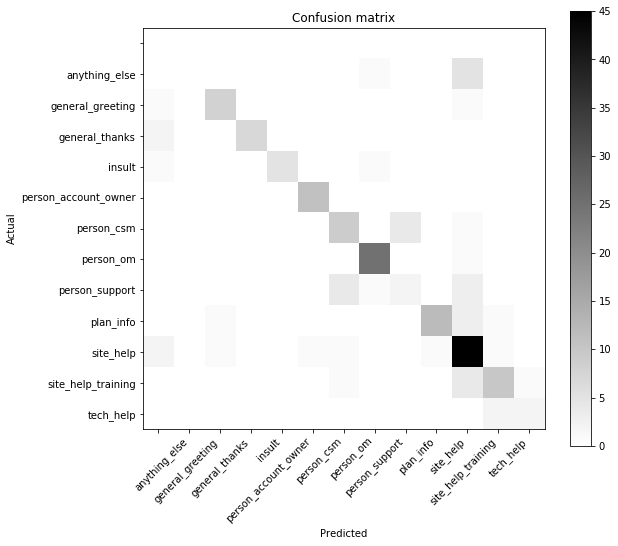

In [16]:
#%matplotlib inline
assistConfMatrix.plot()

In [17]:
# Compute accuracy of classification
acc=accuracy_score(AllTestClasses, AllPredict_Classes)
print ('Classification Accuracy: ', acc)

Classification Accuracy:  0.747252747253


In [18]:
# print precision, recall and f1-scores for the different classes
print(classification_report(AllTestClasses, AllPredict_Classes, labels=labels))

                      precision    recall  f1-score   support

          person_csm       0.60      0.64      0.62        14
           person_om       0.89      0.96      0.93        26
           site_help       0.71      0.87      0.78        52
           tech_help       0.67      0.50      0.57         4
           plan_info       0.92      0.71      0.80        17
              insult       1.00      0.71      0.83         7
    general_greeting       0.80      0.80      0.80        10
      person_support       0.33      0.20      0.25        10
       anything_else       0.00      0.00      0.00         6
  site_help_training       0.71      0.62      0.67        16
      general_thanks       1.00      0.78      0.88         9
person_account_owner       0.92      1.00      0.96        11

         avg / total       0.75      0.75      0.74       182



/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [19]:
#Optional if you would like each of these metrics separately
#[precision,recall,fscore,support]=precision_recall_fscore_support(AllTestClasses, AllPredict_Classes, labels=labels)
#print ('precision: ', precision)
#print ('recall: ', recall)
#print ('f1 score: ', fscore)
#print ('support: ', support)

# Now see if user wants to apply this against their current skill

Ask the user if they want to apply this against their current skill - and if they do, then go and delete all current intents, and then create the new intents and apply ALL of the new training data.

In [20]:
#DEBUG=True
DEBUG=False
stat=True
#
# Remind user whgat their target workspace/skill is - and then ask the question
#
#
Assistant_content=getAssistantWorkspaceContent(assistant_v1,assist_workspace_id)
#
if (DEBUG):
    print(json.dumps(Assistant_content, indent=2))
print ('Workspace/Skill name - ', Assistant_content['name'])
print ('          Description -', Assistant_content['description'])
#
Apply = input('Would you like to apply this data against your current skill/workspace? (yes/no)').lower()
if Apply != 'yes':   
    print ('New data not applied - Processing complete.')
else:
    print ('Removing old intent, and applying new training data...')
    #
    # Otherwise we are applying against the current skill/workspace
    #
    # get a list of all of the current intents, and then delete them all
    #
    oldIntentList = getAssistantWorkspaceIntents(assistant_v1,assist_workspace_id)
    if (DEBUG):
        print(oldIntentList)
    stat = deleteAssistantWorkspaceIntents(assistant_v1,assist_workspace_id,oldIntentList)
    stat = waitAssistantWorkspace(assistant_v1,assist_workspace_id,30)
    #
    # Create new intents, conduct training with new intents
    #
    stat = trainAssistantWorkspaceIntents(assistant_v1,assist_workspace_id,intent_classes_dict,intent_data_dict)


Workspace/Skill name -  CSM Skill
          Description - 
Would you like to apply this data against your current skill/workspace? (yes/no)no
New data not applied - Processing complete.
